In [1]:
# library
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [2]:
# training hyper-parameter
lr = 1e-3
batch_size = 4
num_epoch = 100
data_dir = './datasets'
ckpt_dir = './checkpoint'
log_dir = './log'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Unet network
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                kernel_sieze = kernel_size, stride = stride, padding = padding,
                                bias = bias)]
            
            layers += [nn.BatchNorm2(num_features = out_channels)]
            layers += [nn.ReLu()]
            
            cbr = nn.Sequential(*layers)
            
            return cbr
        
        # Contracting path
        self.enc1_1 = CBR2d(in_channels = 1, out_channels = 64)
        self.enc1_2 = CBR2d(in_channels = 64, out_channels = 64)
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc2_1 = CBR2d(in_channels = 64, out_channels = 128)
        self.enc2_2 = CBR2d(in_channels = 128, out_channels = 128)
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc3_1 = CBR2d(in_channels = 128, out_channels = 256)
        self.enc3_2 = CBR2d(in_channels = 256, out_channels = 256)
        
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc4_1 = CBR2d(in_channels = 256, out_channels = 512)
        self.enc4_2 = CBR2d(in_channels = 512, out_channels = 512)
        
        self.pool4 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc5_1 = CBR2d(in_channels = 512, out_channels = 1024)
        
        
        self.dec5_1 = CBR2d(in_channels = 1024, out_channels = 512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                        kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias = True)
        
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        
        enc2_1 = self.enc1_1(pool1)
        enc2_2 = self.enc1_2(enc2_1)
        pool2 = self.pool1(enc2_2)
        
        enc3_1 = self.enc1_1(pool2)
        enc3_2 = self.enc1_2(enc3_1)
        pool3 = self.pool1(enc3_2)
        
        enc4_1 = self.enc1_1(pool3)
        enc4_2 = self.enc1_2(enc4_1)
        pool4 = self.pool1(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        
        dec5_1 = self.dec5_1(ecn5_1)
        
        unpool4 = self.unpool4(dec5_1)
        # dim은 채널 방향, dim = [0:batch, 1:channel, 2:height, 3:width]
        cat4 = torch.cat((unpool4, enc4_2), dim = 1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim = 1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_1)
        
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim = 1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_1)
        
        unpool1 = self.unpool3(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim = 1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_1)
        
        x = self.fc(dec1_1)
        
        return x

In [12]:
# DataLoader 

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        
        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        
        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input
        
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        label = label/255.0
        input = input/255.0
        
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        
        if input.ndim == 2:
            input = input[:, :, np.newaxis]
            
        data = {'input':input, 'label':label}
        
        if self.transform:
            data = self.transform(data)
        
        return data
        
        

In [14]:
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

In [19]:
# Trnasform function

# ToTensor(): numpy -> tensor

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        # Image의 numpy dimension = (Y, X, CH)
        # Image의 tensor dimension = (CH, Y, X)
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)
        
        data = {'input':torch.from_numpy(input), 'label':torch.from_numpy(label)}
        
        return data

In [20]:
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std
    
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        input = (input - self.mean) / self.std
        data = {'label':label, 'input':input}
        
        return data

In [22]:
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
            
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)
        
        data = {'label':label, 'input':input}
        
        return data

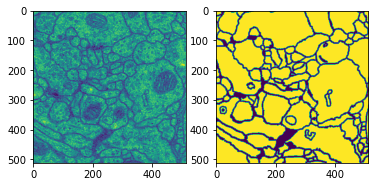

In [24]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'), transform = transform)

data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()